In [12]:
import pandas as pd
from tueplots import bundles, figsizes
import matplotlib.pyplot as plt
import numpy as np
import warnings
import concurrent.futures
from matplotlib.ticker import MaxNLocator

In [ ]:
# To suppress all warnings, because we get a warning for one of the fonts that we used
warnings.filterwarnings("ignore")

# Custom color pallet

In the following cells we define a custom color pallet for our plots.


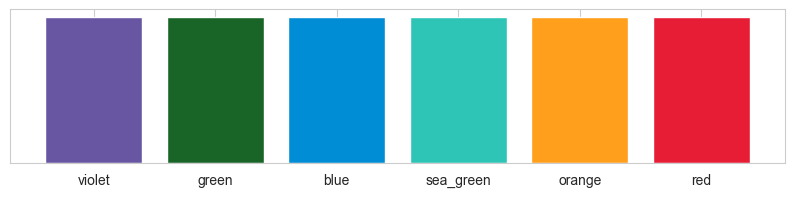

In [13]:
# Custom color palette
cColorPal = {'violet' : '#6956a3','green' : '#196528', 'blue' : '#008dd5','sea_green': '#2ec4b6',  'orange' : '#ff9f1c', 'red' : '#e71d36'}

# Create a figure and a subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

# Plot each color as a bar
for i, color in enumerate(cColorPal.values()):
    ax.bar(i, 1, color=color)

# Remove y-axis
ax.get_yaxis().set_visible(False)

# Set x-axis ticks to color names
ax.set_xticks(range(len(cColorPal)))
ax.set_xticklabels(cColorPal.keys())

plt.show()


# Utility functions

These are our utility functions that help create the plots and models

In [14]:
# Merge all dataframes and rename the count columns
def rename_merge(dataframes, suffixes):
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].copy()

        for column in dataframes[i].columns:
            if(column == 'frame.time'):
                continue
            dataframes[i].rename(columns={column: f'{column}_{suffixes[i]}'}, inplace=True)

    merge_df = dataframes[0]

    for dataframe in dataframes[1:]:
        merge_df = merge_df.merge(dataframe, how='outer', on='frame.time')

    return merge_df.dropna()

In [15]:
#  Change the time format to string
def keepOnlyTime(data):
    data = data.copy()
    data['frame.time'] = data['frame.time'].dt.time.astype(str)
    data["frame.time"] = data["frame.time"].str.replace(r':\d{2}$', '', regex=True)

    return data

In [60]:
# Create enter_count many random values and use them to create a new sum with a discrete distribution
def random_counts(enter_count):
   r = np.random.uniform(0, 1, enter_count)
   r_c = np.where(r >= 0.83, np.where(r >= 0.90, 0, 2 ), 1)
   return r_c.sum()

In [61]:
# Create a cumulative sum of first and last seen entries
def getcumSumMerged(data) :

    data = data.copy()
    data['count_CumSum'] = data['count_First'].cumsum() - data['count_Last'].cumsum()

    return data


In [88]:
# Resamples the dataframe to specific time frames
def ResampleToXTime(periode, data):

    # Set 'time' column as index
    data.set_index('frame.time', inplace=True)

    # Resample and sum up 'count' every x minutes
    resampled_data = data.resample(periode + 'Min').sum()

    # Reset index
    resampled_data.reset_index(inplace=True)

    return resampled_data

# Load data as csv files

In this section we are loading our own data files. If you want to use these function, you have to collect your own data using Wireshark.

In [22]:
onedrive_path = r"C:\Users\Philipp\OneDrive - UT Cloud"
dMonday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/080124Monday.csv')
print("Monday loaded")
dTuesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/090124Tuesday.csv')
print("Tuesday loaded")
dWednesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/100124Wednesday.csv')
print("Wednesday loaded")
dThursday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/110124Thursday.csv')
print("Thursday loaded")
dFriday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/120124Friday.csv')
print("Friday loaded")

Monday loaded
Tuesday loaded
Wednesday loaded
Thursday loaded
Friday loaded


## Change data types and reassure rightly loaded csv

In [23]:
# This method changes the datatype of the column frame.time to date-time in format ISO8601
def changeDataTypes(data, day):

    try: 
        data['frame.time'] = pd.to_datetime(data['frame.time'], format='ISO8601')
        data = data.drop('Unnamed: 0', axis=1)
        data = data.reset_index(drop=True)
    except Exception as e:
        print(f"There was the exception: {e} in {day}")
    
    print(f"{day} time processed")

    return data

In [24]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    dMonday_future = executor.submit(changeDataTypes, dMonday, "Monday")
    dTuesday_future = executor.submit(changeDataTypes, dTuesday, "Tuesday")
    dWednesday_future = executor.submit(changeDataTypes, dWednesday, "Wednesday")
    dThursday_future = executor.submit(changeDataTypes, dThursday, "Thursday")
    dFriday_future = executor.submit(changeDataTypes, dFriday, "Friday")

dMonday = dMonday_future.result()
dTuesday = dTuesday_future.result()
dWednesday = dWednesday_future.result()
dThursday = dThursday_future.result()
dFriday = dFriday_future.result()

Tuesday time processed
Friday time processed
Thursday time processed
Monday time processed
Wednesday time processed


# Filter data to keep only requested data

In [57]:
# filter for devices that communicate with our selected ssids 
def filter(data):
    # data = data.copy()
    eduroam_ssid = "656475726f616d"
    UTGuest_ssid = "55546775657374"
    Guest_ssid = "4775657374"

    # All data filtered for eduroam, UTGuest and Guest
    df = data.loc[(data["wlan.ssid"] == eduroam_ssid)|(data["wlan.ssid"] == UTGuest_ssid )|( data["wlan.ssid"] == Guest_ssid)]

    # all unique mac addresses with the ssids
    all_sources = df["wlan.sa"].unique().tolist()
    combined_macs = list(set(all_sources))

    print("\n")
    print(f"Number of unique mac addresses verified by ssid: {len(all_sources)}")

    # Drop NaNs and sort for time
    data.dropna(subset=['wlan.sa'], inplace = True)
    data['wlan.ssid'].value_counts().sort_index(inplace=True)

    # All entries that use the resulting mac addresses
    return data.loc[data['wlan.sa'].isin(combined_macs)]

In [58]:
# use filter method
dFilteredMonday = filter(dMonday)
dFilteredTuesday  = filter(dTuesday)
dFilteredWednesday  = filter(dWednesday)
dFilteredThursday  = filter(dThursday)
dFilteredFriday  = filter(dFriday)



Number of unique mac addresses verified by ssid: 1716


Number of unique mac addresses verified by ssid: 3565


Number of unique mac addresses verified by ssid: 1914


Number of unique mac addresses verified by ssid: 2047


Number of unique mac addresses verified by ssid: 2763


# Create Dataframe of first and last seen source mac addresses 

In [59]:
dFirstMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()

# Count Dataframe

These dataframes count how many source mac addresses there are in first and last seen and return a one column dataframe

In [28]:
dCountFirstMonday = pd.DataFrame(dFirstMonday['frame.time'].value_counts().sort_index())
dCountLastMonday = pd.DataFrame(dLastMonday['frame.time'].value_counts().sort_index())
dCountFirstTuesday = pd.DataFrame(dFirstTuesday['frame.time'].value_counts().sort_index())
dCountLastTuesday = pd.DataFrame(dLastTuesday['frame.time'].value_counts().sort_index())
dCountFirstWednesday = pd.DataFrame(dFirstWednesday['frame.time'].value_counts().sort_index())
dCountLastWednesday = pd.DataFrame(dLastWednesday['frame.time'].value_counts().sort_index())
dCountFirstThursday = pd.DataFrame(dFirstThursday['frame.time'].value_counts().sort_index())
dCountLastThursday = pd.DataFrame(dLastThursday['frame.time'].value_counts().sort_index())
dCountFirstFriday = pd.DataFrame(dFirstFriday['frame.time'].value_counts().sort_index())
dCountLastFriday = pd.DataFrame(dLastFriday['frame.time'].value_counts().sort_index())

# Resample for every time

Here we resample for one minute and five minutes

In [29]:
d1CountFirstMonday = ResampleToXTime('1',dCountFirstMonday)
d1CountFirstTuesday = ResampleToXTime('1',dCountFirstTuesday)
d1CountFirstWednesday = ResampleToXTime('1',dCountFirstWednesday)
d1CountFirstThursday = ResampleToXTime('1',dCountFirstThursday)
d1CountFirstFriday = ResampleToXTime('1',dCountFirstFriday)

d1CountLastMonday = ResampleToXTime('1',dCountLastMonday)
d1CountLastTuesday = ResampleToXTime('1',dCountLastTuesday)
d1CountLastWednesday = ResampleToXTime('1',dCountLastWednesday)
d1CountLastThursday = ResampleToXTime('1',dCountLastThursday)
d1CountLastFriday = ResampleToXTime('1',dCountLastFriday)

In [30]:
d5CountFirstMonday = ResampleToXTime('5', dCountFirstMonday)
d5CountLastMonday = ResampleToXTime('5', dCountLastMonday)
d5CountFirstTuesday = ResampleToXTime('5', dCountFirstTuesday)
d5CountLastTuesday = ResampleToXTime('5', dCountLastTuesday)
d5CountFirstWednesday = ResampleToXTime('5', dCountFirstWednesday)
d5CountLastWednesday = ResampleToXTime('5', dCountLastWednesday)
d5CountFirstThursday = ResampleToXTime('5', dCountFirstThursday)
d5CountLastThursday = ResampleToXTime('5', dCountLastThursday)
d5CountFirstFriday = ResampleToXTime('5', dCountFirstFriday)
d5CountLastFriday = ResampleToXTime('5', dCountLastFriday)

# Merge Last  & First

Here we merge the first and last seen counts for each day

In [31]:
d1FirstLastMonday = rename_merge([d1CountFirstMonday, d1CountLastMonday], ['First', 'Last'])
d1FirstLastTuesday = rename_merge([d1CountFirstTuesday, d1CountLastTuesday], ['First', 'Last'])
d1FirstLastWednesday = rename_merge([d1CountFirstWednesday, d1CountLastWednesday], ['First', 'Last'])
d1FirstLastThursday = rename_merge([d1CountFirstThursday, d1CountLastThursday], ['First', 'Last'])
d1FirstLastFriday = rename_merge([d1CountFirstFriday, d1CountLastFriday], ['First', 'Last'])

In [32]:
d5FirstLastMonday = rename_merge([d5CountFirstMonday, d5CountLastMonday], ['First', 'Last'])
d5FirstLastTuesday = rename_merge([d5CountFirstTuesday, d5CountLastTuesday], ['First', 'Last'])
d5FirstLastWednesday = rename_merge([d5CountFirstWednesday, d5CountLastWednesday], ['First', 'Last'])
d5FirstLastThursday = rename_merge([d5CountFirstThursday, d5CountLastThursday], ['First', 'Last'])
d5FirstLastFriday = rename_merge([d5CountFirstFriday, d5CountLastFriday], ['First', 'Last'])

# Cumulative Sum

Then we calculate the cumulative sum for first and last seen

In [72]:
d5FirstLastCumSumMonday =  getcumSumMerged(d5FirstLastMonday)
d5FirstLastCumSumTuesday =  getcumSumMerged(d5FirstLastTuesday)
d5FirstLastCumSumWednesday =  getcumSumMerged(d5FirstLastWednesday)
d5FirstLastCumSumThursday =  getcumSumMerged(d5FirstLastThursday)
d5FirstLastCumSumFriday =  getcumSumMerged(d5FirstLastFriday)

In [73]:
d1FirstLastCumSumMonday =  getcumSumMerged(d1FirstLastMonday)
d1FirstLastCumSumTuesday =  getcumSumMerged(d1FirstLastTuesday)
d1FirstLastCumSumWednesday =  getcumSumMerged(d1FirstLastWednesday)
d1FirstLastCumSumThursday =  getcumSumMerged(d1FirstLastThursday)
d1FirstLastCumSumFriday =  getcumSumMerged(d1FirstLastFriday)

# Correct for offset

Since we have to synchronise all our data frame to the same time, we have to cut of some of the first and last entries. 
To correct for this, we have to add an offset to the data, so that we do not have a negative number of people in the Mensa.

In [35]:
# This method searches for the minimum for each day and adds it to the data as an offset
def correctData(data):

    cData = data.copy()

    if(cData['count_CumSum'].min() < 0) :
        cData['count_CumSum'] = cData['count_CumSum'] + abs(cData['count_CumSum'].min())

    return cData

In [74]:
d1FirstLastCumSumMonday = correctData(d1FirstLastCumSumMonday)
d1FirstLastCumSumTuesday = correctData(d1FirstLastCumSumTuesday)
d1FirstLastCumSumWednesday = correctData(d1FirstLastCumSumWednesday)
d1FirstLastCumSumThursday = correctData(d1FirstLastCumSumThursday)
d1FirstLastCumSumFriday = correctData(d1FirstLastCumSumFriday)

In [75]:
d5FirstLastCumSumMonday = correctData(d5FirstLastCumSumMonday)
d5FirstLastCumSumTuesday = correctData(d5FirstLastCumSumTuesday)
d5FirstLastCumSumWednesday = correctData(d5FirstLastCumSumWednesday)
d5FirstLastCumSumThursday = correctData(d5FirstLastCumSumThursday)
d5FirstLastCumSumFriday = correctData(d5FirstLastCumSumFriday)

# CSV export and import

Here we are exporting and importing our data, so that the results can be reproduced

In [65]:
# This is the cell for the export. Only execute this cell if you have the raw data
d1FirstLastCumSumMonday.to_csv(r'./data/d1FirstLastCumSumMonday.csv')
d1FirstLastCumSumTuesday.to_csv(r'./data/d1FirstLastCumSumTuesday.csv') 
d1FirstLastCumSumWednesday.to_csv(r'./data/d1FirstLastCumSumWednesday.csv')
d1FirstLastCumSumThursday.to_csv(r'./data/d1FirstLastCumSumThursday.csv')
d1FirstLastCumSumFriday.to_csv(r'./data/d1FirstLastCumSumFriday.csv')

d5FirstLastCumSumMonday.to_csv(r'./data/d5FirstLastCumSumMonday.csv')
d5FirstLastCumSumTuesday.to_csv(r'./data/d5FirstLastCumSumTuesday.csv') 
d5FirstLastCumSumWednesday.to_csv(r'./data/d5FirstLastCumSumWednesday.csv')
d5FirstLastCumSumThursday.to_csv(r'./data/d5FirstLastCumSumThursday.csv')
d5FirstLastCumSumFriday.to_csv(r'./data/d5FirstLastCumSumFriday.csv')

## Import data for reproduction

In [81]:
# This is the cell for the import.
d1FirstLastCumSumMonday = pd.read_csv(r'./data/d1FirstLastCumSumMonday.csv')
d1FirstLastCumSumTuesday = pd.read_csv(r'./data/d1FirstLastCumSumTuesday.csv') 
d1FirstLastCumSumWednesday = pd.read_csv(r'./data/d1FirstLastCumSumWednesday.csv')
d1FirstLastCumSumThursday = pd.read_csv(r'./data/d1FirstLastCumSumThursday.csv')
d1FirstLastCumSumFriday = pd.read_csv(r'./data/d1FirstLastCumSumFriday.csv')

d5FirstLastCumSumMonday = pd.read_csv(r'./data/d5FirstLastCumSumMonday.csv')
d5FirstLastCumSumTuesday = pd.read_csv(r'./data/d5FirstLastCumSumTuesday.csv') 
d5FirstLastCumSumWednesday = pd.read_csv(r'./data/d5FirstLastCumSumWednesday.csv')
d5FirstLastCumSumThursday = pd.read_csv(r'./data/d5FirstLastCumSumThursday.csv')
d5FirstLastCumSumFriday = pd.read_csv(r'./data/d5FirstLastCumSumFriday.csv')

In [96]:
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     d1FirstLastCumSumMonday_future = executor.submit(changeDataTypes, d1FirstLastCumSumMonday, "Monday")
#     d1FirstLastCumSumMonday_future = executor.submit(changeDataTypes, d1FirstLastCumSumMonday, "Tuesday")
#     dWednesday_future = executor.submit(changeDataTypes, dWednesday, "Wednesday")
#     dThursday_future = executor.submit(changeDataTypes, dThursday, "Thursday")
#     dFriday_future = executor.submit(changeDataTypes, dFriday, "Friday")

d1FirstLastCumSumMonday = changeDataTypes(d1FirstLastCumSumMonday, "Monday")
d1FirstLastCumSumTuesday = changeDataTypes(d1FirstLastCumSumTuesday, "Tuesday")
d1FirstLastCumSumWednesday = changeDataTypes(d1FirstLastCumSumWednesday, "Wednesday")
d1FirstLastCumSumThursday = changeDataTypes(d1FirstLastCumSumThursday, "Thursday")
d1FirstLastCumSumFriday = changeDataTypes(d1FirstLastCumSumFriday, "Friday")

d5FirstLastCumSumMonday = changeDataTypes(d5FirstLastCumSumMonday, "Monday")
d5FirstLastCumSumTuesday = changeDataTypes(d5FirstLastCumSumTuesday, "Tuesday")
d5FirstLastCumSumWednesday = changeDataTypes(d5FirstLastCumSumWednesday, "Wednesday")
d5FirstLastCumSumThursday = changeDataTypes(d5FirstLastCumSumThursday, "Thursday")
d5FirstLastCumSumFriday = changeDataTypes(d5FirstLastCumSumFriday, "Friday")

There was the exception: "['Unnamed: 0'] not found in axis" in Monday
Monday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Tuesday
Tuesday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Wednesday
Wednesday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Thursday
Thursday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Friday
Friday time processed
Monday time processed
Tuesday time processed
Wednesday time processed
Thursday time processed
Friday time processed


# Convert from devices to people

In this part, we are using our predefined discrete distribution, to account for people who do not have a device or people who have multiple devices.

In [97]:
def estimate_devices2people(dFirstLastCumSumMonday, nrSimualtion = 1000):
    
    dFirstLastCumSumPeopleMonday = dFirstLastCumSumMonday.copy()

    # CuSum estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_CumSum'].astype(int).apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(nrSimualtion)

    dFirstLastCumSumPeopleMonday['count_CumSum_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_CumSum_people_stderr'] = stderr_counts

    # Last
    # estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_Last'].astype(int).apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(nrSimualtion)

    dFirstLastCumSumPeopleMonday['count_Last_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_Last_people_stderr'] = stderr_counts

    #  First
    # estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_First'].astype(int).apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(nrSimualtion)

    dFirstLastCumSumPeopleMonday['count_First_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_First_people_stderr'] = stderr_counts


    return dFirstLastCumSumPeopleMonday

In [98]:
d1FirstLastCumSumPeopleMonday = estimate_devices2people(d1FirstLastCumSumMonday)
d1FirstLastCumSumPeopleTuesday = estimate_devices2people(d1FirstLastCumSumTuesday)
d1FirstLastCumSumPeopleWednesday = estimate_devices2people(d1FirstLastCumSumWednesday)
d1FirstLastCumSumPeopleThursday = estimate_devices2people(d1FirstLastCumSumThursday)
d1FirstLastCumSumPeopleFriday = estimate_devices2people(d1FirstLastCumSumFriday)

In [99]:
d5FirstLastCumSumPeopleMonday = estimate_devices2people(d5FirstLastCumSumMonday)
d5FirstLastCumSumPeopleTuesday = estimate_devices2people(d5FirstLastCumSumTuesday)
d5FirstLastCumSumPeopleWednesday = estimate_devices2people(d5FirstLastCumSumWednesday)
d5FirstLastCumSumPeopleThursday = estimate_devices2people(d5FirstLastCumSumThursday)
d5FirstLastCumSumPeopleFriday = estimate_devices2people(d5FirstLastCumSumFriday)

# Convert date time to string

## without estimation of people to devices

In [100]:
d5TimeFirstLastCumSumMonday = keepOnlyTime(d5FirstLastCumSumMonday)
d5TimeFirstLastCumSumTuesday = keepOnlyTime(d5FirstLastCumSumTuesday)
d5TimeFirstLastCumSumWednesday = keepOnlyTime(d5FirstLastCumSumWednesday)
d5TimeFirstLastCumSumThursday = keepOnlyTime(d5FirstLastCumSumThursday)
d5TimeFirstLastCumSumFriday = keepOnlyTime(d5FirstLastCumSumFriday)

In [101]:
d1TimeFirstLastCumSumMonday = keepOnlyTime(d1FirstLastCumSumMonday)
d1TimeFirstLastCumSumTuesday = keepOnlyTime(d1FirstLastCumSumTuesday)
d1TimeFirstLastCumSumWednesday = keepOnlyTime(d1FirstLastCumSumWednesday)
d1TimeFirstLastCumSumThursday = keepOnlyTime(d1FirstLastCumSumThursday)
d1TimeFirstLastCumSumFriday = keepOnlyTime(d1FirstLastCumSumFriday)

## with conversion of people to devices

In [102]:
d5TimeFirstLastCumSumPeopleMonday = keepOnlyTime(d5FirstLastCumSumPeopleMonday)
d5TimeFirstLastCumSumPeopleTuesday = keepOnlyTime(d5FirstLastCumSumPeopleTuesday)
d5TimeFirstLastCumSumPeopleWednesday = keepOnlyTime(d5FirstLastCumSumPeopleWednesday)
d5TimeFirstLastCumSumPeopleThursday = keepOnlyTime(d5FirstLastCumSumPeopleThursday)
d5TimeFirstLastCumSumPeopleFriday = keepOnlyTime(d5FirstLastCumSumPeopleFriday)

In [103]:
d1TimeFirstLastCumSumPeopleMonday = keepOnlyTime(d1FirstLastCumSumPeopleMonday)
d1TimeFirstLastCumSumPeopleTuesday = keepOnlyTime(d1FirstLastCumSumPeopleTuesday)
d1TimeFirstLastCumSumPeopleWednesday = keepOnlyTime(d1FirstLastCumSumPeopleWednesday)
d1TimeFirstLastCumSumPeopleThursday = keepOnlyTime(d1FirstLastCumSumPeopleThursday)
d1TimeFirstLastCumSumPeopleFriday = keepOnlyTime(d1FirstLastCumSumPeopleFriday)

# Queue 

In this part of the code we define the queue models

## Baseline queue model

In [104]:
def naive_queue_model(countFirst, nr_counters = 3, serving_speed = 6):
    
    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        #print(i)
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count_First_people_mean'].iloc[i] - nr_counters * serving_speed)
        else:
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count_First_people_mean'].iloc[i] - nr_counters * serving_speed)

    return queueCount
    

In [105]:
d1TimeFirstLastCumSumQueuePeopleMonday1 = naive_queue_model(d1TimeFirstLastCumSumPeopleMonday)
d1TimeFirstLastCumSumQueuePeopleTuesday1 = naive_queue_model(d1TimeFirstLastCumSumPeopleTuesday)
d1TimeFirstLastCumSumQueuePeopleWednesday1 = naive_queue_model(d1TimeFirstLastCumSumPeopleWednesday)
d1TimeFirstLastCumSumQueuePeopleThursday1 = naive_queue_model(d1TimeFirstLastCumSumPeopleThursday)
d1TimeFirstLastCumSumQueuePeopleFriday1 = naive_queue_model(d1TimeFirstLastCumSumPeopleFriday)

## Queue_model

In [106]:
def queue_model(countFirst, nr_counters = 3, serving_speed = 6):
    
    max_serve_speed = 20

    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0
    queueCount['serving_speed'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count_First_people_mean'].iloc[i] - nr_counters * serving_speed)
            queueCount['serving_speed'][i] = 0
        else:
            serving_speed_estimation = min(max_serve_speed, serving_speed * queueCount['queue_count'].iloc[i-1]/nr_counters)
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count_First_people_mean'].iloc[i] - np.round(serving_speed_estimation))
            queueCount['serving_speed'][i] = serving_speed_estimation

    return queueCount

In [107]:
d1TimeFirstLastCumSumQueuePeopleMonday2 = queue_model(d1TimeFirstLastCumSumPeopleMonday)
d1TimeFirstLastCumSumQueuePeopleTuesday2 = queue_model(d1TimeFirstLastCumSumPeopleTuesday)
d1TimeFirstLastCumSumQueuePeopleWednesday2 = queue_model(d1TimeFirstLastCumSumPeopleWednesday)
d1TimeFirstLastCumSumQueuePeopleThursday2 = queue_model(d1TimeFirstLastCumSumPeopleThursday)
d1TimeFirstLastCumSumQueuePeopleFriday2 = queue_model(d1TimeFirstLastCumSumPeopleFriday)

## Queue Model uncertainty SP and PC

In [108]:
def queue_model_uncertaintySP_PC(dFirstLastCumSumPeopleMonday, mean_serving_speed = 6, std_dev_serving_speed = 1, nr_counters = 3, max_serve_speed = 20, num_simulations=1000):
    

    queueCount = dFirstLastCumSumPeopleMonday.copy()
    
    queueCount['serving_speed'] = 0

    # Run multiple simulations
    all_simulations = []
    for _  in range(num_simulations):
        queueCount['queue_count'] = 0
        for i in range(len(queueCount)):
            # random serving speed
            serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
            serving_speed = max(serving_speed, 0)

            if i == 0: #timepoint 0
                queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count_First_people_mean'].iloc[i] - serving_speed)
                serving_speed_estimation = 0  
            else:
                serving_speed_estimation = min(max_serve_speed, serving_speed + (queueCount['queue_count'].iloc[i-1]/nr_counters))
                queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count_First_people_mean'].iloc[i] - np.round(serving_speed_estimation))

            queueCount['serving_speed'][i] = serving_speed_estimation
        # print(queueCount['serving_speed'][i])

        all_simulations.append(queueCount['queue_count'])

    all_simulations = np.array(all_simulations)

    # Calculate mean and standard error at each minute
    mean_queue_counts = all_simulations.mean(axis=0)
    stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(num_simulations)


    queueCount['queue_mean_count'] = mean_queue_counts
    queueCount['queue_stderr_count'] = stderr_queue_counts

    return queueCount

In [109]:
# This might take some time to execute
d1TimeFirstLastCumSumQueuePeopleMonday3 = queue_model_uncertaintySP_PC(d1TimeFirstLastCumSumPeopleMonday)
d1TimeFirstLastCumSumQueuePeopleTuesday3 = queue_model_uncertaintySP_PC(d1TimeFirstLastCumSumPeopleTuesday)
d1TimeFirstLastCumSumQueuePeopleWednesday3 = queue_model_uncertaintySP_PC(d1TimeFirstLastCumSumPeopleWednesday)
d1TimeFirstLastCumSumQueuePeopleThursday3 = queue_model_uncertaintySP_PC(d1TimeFirstLastCumSumPeopleThursday)
d1TimeFirstLastCumSumQueuePeopleFriday3 = queue_model_uncertaintySP_PC(d1TimeFirstLastCumSumPeopleFriday)

# Merge Dataframes together in one

Here we are merging all our data frames so that they can be used for the plots

In [110]:
d5DevicesWeek = rename_merge([d5TimeFirstLastCumSumMonday, d5TimeFirstLastCumSumTuesday, d5TimeFirstLastCumSumWednesday, d5TimeFirstLastCumSumThursday, d5TimeFirstLastCumSumFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

In [111]:
d5PeopleWeek = rename_merge([d5TimeFirstLastCumSumPeopleMonday, d5TimeFirstLastCumSumPeopleTuesday, d5TimeFirstLastCumSumPeopleWednesday, d5TimeFirstLastCumSumPeopleThursday, d5TimeFirstLastCumSumPeopleFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

In [112]:
# Merge all dataframes with estimation together in one dataframe
d1PeopleQueueWeek3 = rename_merge([d1TimeFirstLastCumSumQueuePeopleMonday3, d1TimeFirstLastCumSumQueuePeopleTuesday3, d1TimeFirstLastCumSumQueuePeopleWednesday3, d1TimeFirstLastCumSumQueuePeopleThursday3, d1TimeFirstLastCumSumQueuePeopleFriday3], ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday'])

In [122]:
d1PeopleQueueWeek2 = rename_merge([d1TimeFirstLastCumSumQueuePeopleMonday2, d1TimeFirstLastCumSumQueuePeopleTuesday2, d1TimeFirstLastCumSumQueuePeopleWednesday2, d1TimeFirstLastCumSumQueuePeopleThursday2, d1TimeFirstLastCumSumQueuePeopleFriday2], ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday'])

In [123]:
d1PeopleQueueWeek1 = rename_merge([d1TimeFirstLastCumSumQueuePeopleMonday1, d1TimeFirstLastCumSumQueuePeopleTuesday1, d1TimeFirstLastCumSumQueuePeopleWednesday1, d1TimeFirstLastCumSumQueuePeopleThursday1, d1TimeFirstLastCumSumQueuePeopleFriday1], ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday'])

# Plots

In this section we are creating the plots for our models

## Queue

Here we plot different queue models for each day.

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


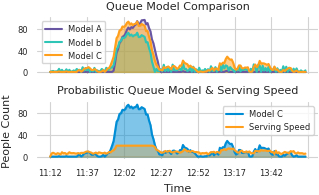

In [113]:
# Here we are setting up our parameters for our queue plots

plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

ci_lower = d1TimeFirstLastCumSumQueuePeopleMonday3['queue_mean_count'] - 1.96 * d1TimeFirstLastCumSumQueuePeopleMonday3['queue_stderr_count']
ci_upper = d1TimeFirstLastCumSumQueuePeopleMonday3['queue_mean_count'] + 1.96 * d1TimeFirstLastCumSumQueuePeopleMonday3['queue_stderr_count']

fig,  axs = plt.subplots(nrows = 2, ncols = 1, sharex=True)

axs[0].plot(d1TimeFirstLastCumSumQueuePeopleMonday1['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday1['queue_count'], label='Model A', color= cColorPal['violet'])
axs[0].fill_between(d1TimeFirstLastCumSumQueuePeopleMonday1['frame.time'],d1TimeFirstLastCumSumQueuePeopleMonday1['queue_count'], color= cColorPal['violet'], alpha=0.2)

axs[0].plot(d1TimeFirstLastCumSumQueuePeopleMonday2['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday2['queue_count'], label='Model b', color= cColorPal['sea_green'])
axs[0].fill_between(d1TimeFirstLastCumSumQueuePeopleMonday2['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday2['queue_count'], color= cColorPal['sea_green'], alpha=0.5)

axs[0].plot(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['queue_count'], color=cColorPal['orange'], label='Model C')
axs[0].fill_between(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['queue_count'], color=cColorPal['orange'], alpha=0.5)

axs[1].plot(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['queue_count'], color=cColorPal['blue'], label='Model C')
axs[1].fill_between(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['queue_count'], color=cColorPal['blue'], alpha=0.5)

axs[1].plot(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['serving_speed'], color=cColorPal['orange'], label='Serving Speed')
axs[1].fill_between(d1TimeFirstLastCumSumQueuePeopleMonday3['frame.time'], d1TimeFirstLastCumSumQueuePeopleMonday3['serving_speed'], color=cColorPal['orange'], alpha=0.3)

# # Get current ticks
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()

titles = ['Queue Model Comparison', 'Probabilistic Queue Model & Serving Speed']

for i, ax in enumerate(axs):
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.grid(True, color='lightgrey')
    ax.set_title(titles[i])  # Add a title to each subplot

# Remove the box (spines) around the plot
for ax in axs:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

plt.legend(loc="best", fontsize="small")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("People Count")
plt.title("Probabilistic Queue Model & Serving Speed")

# Add a shared y-axis label
axs[0].legend()
axs[1].legend()

plt.savefig('./plots/queueComparison.pdf')

plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


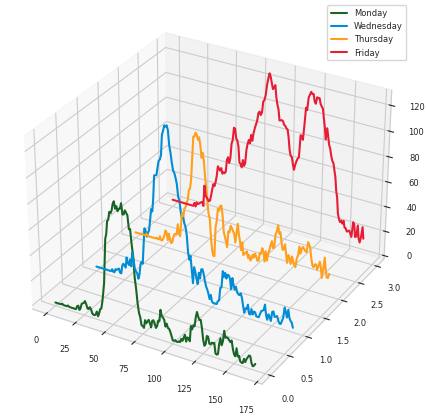

In [124]:
# You can set your queue model here
queueModel = d1PeopleQueueWeek3

plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

# Create a new figure and add a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create an array of offsets
offsets = np.array([0, 1, 2, 3, 4])

# Plot each day of the week with an offset
ax.plot(queueModel.index, queueModel['queue_count_Monday'] + offsets[0], zs=0, zdir='y', label='Monday', color=cColorPal['green'])
ax.plot(queueModel.index, queueModel['queue_count_Wednesday'] + offsets[1], zs=1, zdir='y', label='Wednesday', color=cColorPal['blue'])
ax.plot(queueModel.index, queueModel['queue_count_Thursday'] + offsets[2], zs=2, zdir='y', label='Thursday', color=cColorPal['orange'])
ax.plot(queueModel.index, queueModel['queue_count_Friday'] + offsets[3], zs=3, zdir='y', label='Friday', color=cColorPal['red'])

# Rotate the plot
# ax.view_init(elev=20, azim=45)

# Add a legend
ax.legend()

# Show the plot
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


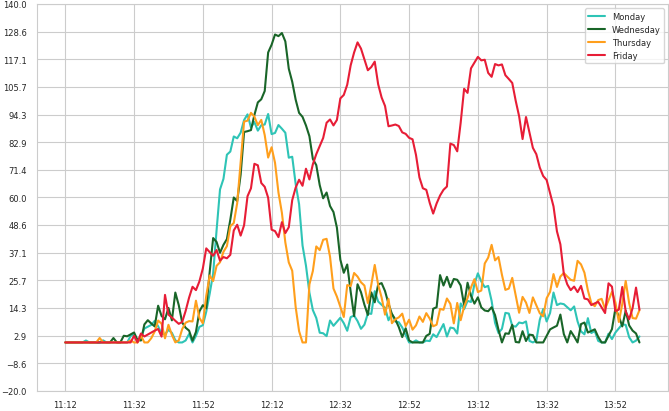

In [115]:
# You can set your queue model here
queueModel = d1PeopleQueueWeek3

plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.plot(queueModel['frame.time'],queueModel['queue_count_Monday'], label='Monday', color=cColorPal['sea_green'])
# plt.plot(queueModel['frame.time'],queueModel['queue_count_Tuesday'], label='Tuesday', color=cColorPal['blue'])
plt.plot(queueModel['frame.time'],queueModel['queue_count_Wednesday'], label='Wednesday', color=cColorPal['green'])
plt.plot(queueModel['frame.time'],queueModel['queue_count_Thursday'], label='Thursday', color=cColorPal['orange'])
plt.plot(queueModel['frame.time'],queueModel['queue_count_Friday'], label='Friday', color=cColorPal['red'])
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=15))
plt.xticks(locsx[::20])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()


## Count

Here we plot the count of mac addresse for each day. We plot when we first seem them and when we last see them.

### First Seen

A plot of the first seen mac addresses for all days

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


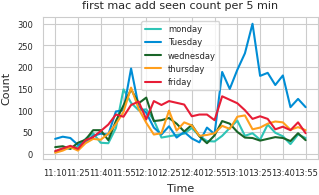

In [116]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_First_Monday'], label='monday', color=cColorPal['sea_green'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_First_Tuesday'], label='Tuesday', color=cColorPal['blue'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_First_Wednesday'], label='wednesday', color=cColorPal['green'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_First_Thursday'], label='thursday', color=cColorPal['orange'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_First_Friday'], label='friday', color=cColorPal['red'])
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('first mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::3])


plt.savefig('./plots/first_seen_mac_per_5_min.pdf')

### Last Seen

A plot of the last seen mac addresses for all days

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


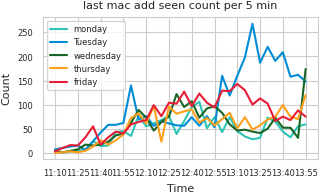

In [117]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_Last_Monday'], label='monday', color=cColorPal['sea_green'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_Last_Tuesday'], label='Tuesday', color=cColorPal['blue'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_Last_Wednesday'], label='wednesday', color=cColorPal['green'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_Last_Thursday'], label='thursday', color=cColorPal['orange'])
plt.plot(d5PeopleWeek['frame.time'], d5PeopleWeek['count_Last_Friday'], label='friday', color=cColorPal['red'])
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('last mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::3])


plt.savefig('./plots/last_seen_mac_per_5_min.pdf')

### First, Last & Cumaltive Sum

This is a plot that shows the first seen and last seen time of a mac address and the cumulative sum of both.
The plot only shows these sums for one day.

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


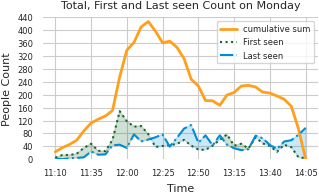

In [119]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.title('Total, First and Last seen Count on Monday')
plt.xlabel('Time')
plt.ylabel('People Count')

plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_CumSum'], color = cColorPal['orange'], label='cumulative sum', linewidth=2)
plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], color = cColorPal['green'], label='First seen', linestyle= ':')
plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_Last'], color = cColorPal['blue'], label='Last seen', linestyle= '-.')

plt.fill_between(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], d5TimeFirstLastCumSumMonday['count_Last'], where=(d5TimeFirstLastCumSumMonday['count_First'] > d5TimeFirstLastCumSumMonday['count_Last']), interpolate=True, color = cColorPal['green'], alpha = 0.2)
plt.fill_between(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], d5TimeFirstLastCumSumMonday['count_Last'], where=(d5TimeFirstLastCumSumMonday['count_First'] <= d5TimeFirstLastCumSumMonday['count_Last']), interpolate=True, color = cColorPal['blue'], alpha = 0.2)
# plt.fill_between(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_CumSum'], color =  cColorPal['orange'], alpha = 0.2)

plt.legend()
# plt.legend(fontsize='large')
plt.grid(True)

locsy, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.arange(0, max(locsy) + 1, 40))
plt.xticks(locs[::5])

# Remove the box (spines) around the plot
ax = plt.gca()
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# plt.xlim([xmin, xmax])
plt.ylim([0, 440])

plt.savefig('./plots/CumSumFirstLastMonday.pdf')

### Cumulative Sum and Queue of all days

This plot shows the queue and the combined cumulative sum of every day

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


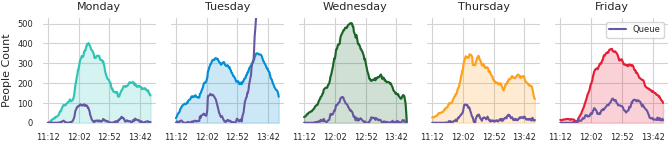

In [120]:
plt.rcParams.update(figsizes.icml2022_full(nrows=1, ncols=5, height_to_width_ratio = 1.1))

fig, axs = plt.subplots(nrows = 1, ncols = 5, sharey=True)  # Create 5 subplots in one row, sharing the same y-axis
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()

# Adjust the space between subplots
plt.subplots_adjust(wspace=5.0)  # Adjust the space between subplots horizontally

# Remove the box (spines) around the plot
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

axs[0].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Monday'], color=cColorPal['sea_green'])
axs[1].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Tuesday'], color=cColorPal['blue'])
axs[2].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Wednesday'], color=cColorPal['green'])
axs[3].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Thursday'], color=cColorPal['orange'])
axs[4].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Friday'], color=cColorPal['red'])

axs[0].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['queue_mean_count_Monday'], color=cColorPal['violet'])
axs[1].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['queue_mean_count_Tuesday'], color=cColorPal['violet'])
axs[2].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['queue_mean_count_Wednesday'], color=cColorPal['violet'])
axs[3].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['queue_mean_count_Thursday'], color=cColorPal['violet'])
axs[4].plot(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['queue_mean_count_Friday'], color=cColorPal['violet'], label ='Queue')

axs[0].fill_between(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Monday'], alpha=0.2, color=cColorPal['sea_green'])
axs[1].fill_between(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Tuesday'], alpha=0.2, color=cColorPal['blue'])
axs[2].fill_between(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Wednesday'], alpha=0.2, color=cColorPal['green'])
axs[3].fill_between(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Thursday'], alpha=0.2, color=cColorPal['orange'])
axs[4].fill_between(d1PeopleQueueWeek3['frame.time'], d1PeopleQueueWeek3['count_CumSum_people_mean_Friday'], alpha=0.2, color=cColorPal['red'])

# Remove the box (spines) around the plot
for ax in axs:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

titles = ['Monday','Tuesday','Wednesday','Thursday','Friday']

for i, ax in enumerate(axs):
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.grid(True, color='lightgrey')
    ax.set_title(titles[i])  # Add a title to each subplot
    # ax.set_xlabel('Time')

axs[0].set_ylabel('People Count')

axs[4].legend()

plt.ylim(0,530)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()

## Cumulative sum for each day in one plot

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


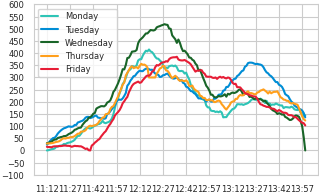

In [121]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.plot(d1PeopleQueueWeek3['frame.time'],d1PeopleQueueWeek3['count_CumSum_Monday'], label='Monday', color=cColorPal['sea_green'])
plt.plot(d1PeopleQueueWeek3['frame.time'],d1PeopleQueueWeek3['count_CumSum_Tuesday'], label='Tuesday', color=cColorPal['blue'])
plt.plot(d1PeopleQueueWeek3['frame.time'],d1PeopleQueueWeek3['count_CumSum_Wednesday'], label='Wednesday', color=cColorPal['green'])
plt.plot(d1PeopleQueueWeek3['frame.time'],d1PeopleQueueWeek3['count_CumSum_Thursday'], label='Thursday', color=cColorPal['orange'])
plt.plot(d1PeopleQueueWeek3['frame.time'],d1PeopleQueueWeek3['count_CumSum_Friday'], label='Friday', color=cColorPal['red'])
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=15))

plt.xticks(locsx[::15])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()
